### Conditional Variational Autoencoder

## Data

In [1]:
import io, re
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df=pd.read_parquet("../../datos/faithful_1.21.1_32x32.parquet")
print(device)

img_size=32

cuda


## Code

informacion relevante:
las imagenes componen valores entre [-1,1] por eso se usa funcion tanh y no sigmoid

In [2]:
def mostrar_resultados(resultados):
    """
    Muestra una lista de imágenes generadas con sus etiquetas.
    """
    plt.figure(figsize=(8, 2))
    for i, (img, label) in enumerate(resultados):
        plt.subplot(1, len(resultados), i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(label)
    plt.tight_layout()
    plt.show()

def generar_imagenes(decoder, text_embedding, prompt: str, n_samples=4, latent_dim=128, device="cuda"):
    # Establecer los modelos en modo evaluación
    decoder.eval()
    text_embedding.eval()

    with torch.no_grad():
        # 1. Embedding condicional del texto
        cond_emb = text_embedding([prompt] * n_samples).to(device)

        # 2. Ruido aleatorio
        z = torch.randn(n_samples, latent_dim, device=device)

        # 3. Generar imágenes usando el decoder
        fake_imgs = decoder(z, cond_emb).detach().cpu()

        # 4. Desnormalizar de [-1, 1] a [0, 1]
        fake_imgs = (fake_imgs * 0.5 + 0.5).clamp(0, 1)

        # 5. Convertir a PIL y devolver
        results = []
        for i in range(n_samples):
            img_pil = TF.to_pil_image(fake_imgs[i])
            results.append((img_pil, prompt))
    
    return results


# Dataset único (con augment)
class MinecraftDataset(Dataset):
    def __init__(self, rows: List[dict], image_size=img_size, augment=False):
        self.rows = rows
        self.image_size = image_size
        self.augment = augment
        self.transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),
            T.Normalize([0.5]*3, [0.5]*3)])

    def __len__(self):
        return len(self.rows)

    def __getitem__(self, idx):
        r = self.rows[idx]
        img = Image.open(io.BytesIO(r["image"]["bytes"])).convert("RGB")
        img_t = self.transform(img)
        if self.augment and torch.rand(1).item() > 0.5:
            img_t = torch.flip(img_t, dims=[2])
        label = r["label"]
        return img_t, label


# Embedding textual (por palabra)
class TextEmbedding(nn.Module):
    def __init__(self, vocab, embed_dim=100):
        super().__init__()
        self.vocab = vocab
        self.stoi = {w: i for i, w in enumerate(vocab)}
        self.embedding = nn.Embedding(len(vocab), embed_dim)

    @staticmethod
    def build_vocab(labels):
        words = set()
        for lbl in labels:
            for w in re.findall(r"\w+", lbl.lower()):
                words.add(w)
        return sorted(words)

    def forward(self, label_texts: List[str]):
        device = next(self.embedding.parameters()).device
        vectors = []
        for text in label_texts:
            tokens = [w for w in re.findall(r"\w+", text.lower()) if w in self.stoi]
            if not tokens:
                tokens = ["unknown"]
            idxs = torch.tensor([self.stoi[w] for w in tokens], device=device)
            emb = self.embedding(idxs).mean(dim=0)
            vectors.append(emb)
        return torch.stack(vectors)

#### Crear modelo

In [ ]:
class Encoder(nn.Module):
    def __init__(self, embed_dim=100, latent_dim=128, ndf=32, img_channels=3):
        super(Encoder, self).__init__()
        
        self.conv = nn.Sequential(
            # --- Bloque 1: 32x32 -> 16x16 ---
            nn.Conv2d(img_channels, ndf, 4, 2, 1), # Downsample
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # Capa extra de profundidad (mantiene tamaño 16x16)
            nn.Conv2d(ndf, ndf, 3, 1, 1), 
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            
            # --- Bloque 2: 16x16 -> 8x8 ---
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1), # Downsample
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Capa extra de profundidad (mantiene tamaño 8x8)
            nn.Conv2d(ndf * 2, ndf * 2, 3, 1, 1),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # --- Bloque 3: 8x8 -> 4x4 ---
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1), # Downsample
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Capa extra de profundidad (mantiene tamaño 4x4)
            nn.Conv2d(ndf * 4, ndf * 4, 3, 1, 1),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # --- Bloque 4: 4x4 -> 2x2 ---
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1), # Downsample
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Capa extra de profundidad (mantiene tamaño 2x2)
            nn.Conv2d(ndf * 8, ndf * 8, 3, 1, 1),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Dimensión aplanada: (ndf*8) * 2 * 2
        self.flat_dim = (ndf * 8) * 2 * 2
        
        self.fc_mu = nn.Linear(self.flat_dim + embed_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flat_dim + embed_dim, latent_dim)

    def forward(self, img, cond_emb):
        x = self.conv(img)
        x = x.flatten(start_dim=1) 
        x = torch.cat([x, cond_emb], dim=1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, embed_dim=100, latent_dim=128, ngf=32, out_channels=3):
        super(Decoder, self).__init__()
        self.ngf = ngf
        
        # Entrada: z + texto -> reconstruir tamaño 2x2
        self.fc_input = nn.Linear(latent_dim + embed_dim, (ngf * 8) * 2 * 2)
        
        self.deconv = nn.Sequential(
            # --- Bloque 1: 2x2 -> 4x4 ---
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1), # Upsample
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # Capa extra (mantiene 4x4) - Usamos Conv2d normal aquí
            nn.Conv2d(ngf * 4, ngf * 4, 3, 1, 1),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # --- Bloque 2: 4x4 -> 8x8 ---
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1), # Upsample
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # Capa extra (mantiene 8x8)
            nn.Conv2d(ngf * 2, ngf * 2, 3, 1, 1),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            # --- Bloque 3: 8x8 -> 16x16 ---
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1), # Upsample
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # Capa extra (mantiene 16x16)
            nn.Conv2d(ngf, ngf, 3, 1, 1),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # --- Bloque 4: 16x16 -> 32x32 ---
            nn.ConvTranspose2d(ngf, out_channels, 4, 2, 1), # Upsample
            nn.Tanh() # Salida final
        )

    def forward(self, z, cond_emb):
        z = z / (z.norm(dim=1, keepdim=True) + 1e-8)
        cond_emb = cond_emb / (cond_emb.norm(dim=1, keepdim=True) + 1e-8)
        x = torch.cat([z, cond_emb], dim=1)
        x = self.fc_input(x)
        x = x.view(-1, self.ngf * 8, 2, 2)
        return self.deconv(x)



# CVAE
class CVAE_Wrapper(nn.Module):
    def __init__(self, encoder, decoder):
        super(CVAE_Wrapper, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, img, cond_emb):
        mu, logvar = self.encoder(img, cond_emb)
        z = self.reparameterize(mu, logvar)
        recon_img = self.decoder(z, cond_emb)
        
        return recon_img, mu, logvar

In [74]:
# === CONFIGURACIÓN ===
latent_dim = 256
embed_dim = 100      # dimensión del embedding textual
ndf = 64
ngf = 64 

batch_size = 32
lr = 5e-4
beta_kl = 0.1 # Peso de la divergencia KL

In [75]:
# Construir vocabulario
all_labels = df["label"].tolist()
cleaned_labels = [re.sub(r"\d+", "", lbl).strip() for lbl in all_labels]
all_labels = list(set(cleaned_labels))

vocab = TextEmbedding.build_vocab(all_labels)

print(f" Vocabulario generado con {len(vocab)} palabras únicas:")
# print(vocab)

# Dataset y DataLoader
dataset = MinecraftDataset(df.to_dict("records"), image_size=img_size, augment=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


 Vocabulario generado con 350 palabras únicas:


#### Entrenamiento

In [76]:
# MODELOS
txt_emb = TextEmbedding(vocab, embed_dim=embed_dim).to(device)
E = Encoder(embed_dim=embed_dim, latent_dim=latent_dim, ndf=ndf).to(device)
D = Decoder(embed_dim=embed_dim, latent_dim=latent_dim, ngf=ngf).to(device)
cvae = CVAE_Wrapper(E, D).to(device)


In [77]:
optimizer = optim.Adam(list(E.parameters()) + list(D.parameters()) + list(txt_emb.parameters()), lr=lr)

def loss_function(recon_x, x, mu, logvar, beta=0.1):
    batch_size = x.size(0)
    
    # mse promedio por img
    MSE = F.mse_loss(recon_x, x, reduction='sum') / batch_size
    
    # KL promedio por img
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
    
    # Pérdida total
    return MSE + (beta * KLD), MSE, KLD

Comenzando entrenamiento CVAE...
Época [0/4000] Loss Total: 916.6227 | Recon (MSE): 907.9590 | KL: 86.6368


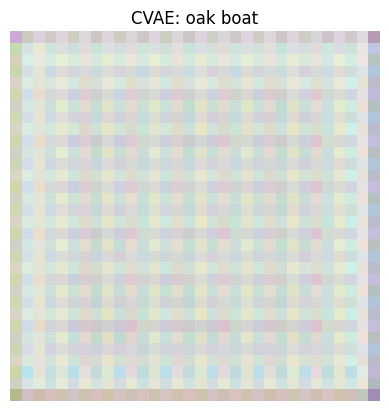

Época [100/4000] Loss Total: 30.7607 | Recon (MSE): 28.4772 | KL: 22.8351


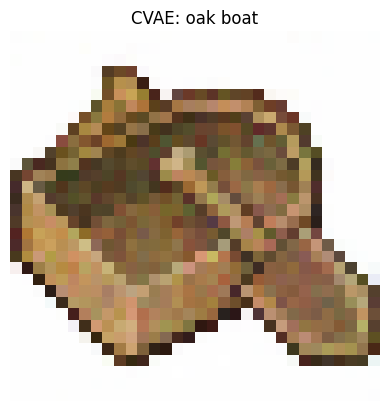

Época [200/4000] Loss Total: 20.8878 | Recon (MSE): 19.4283 | KL: 14.5954


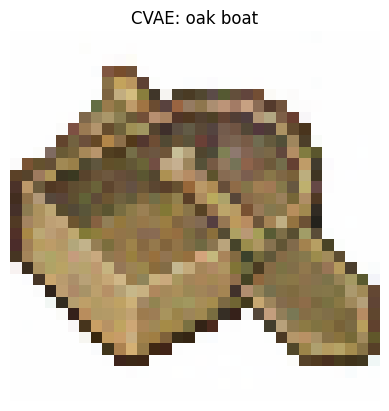

Época [300/4000] Loss Total: 11.7813 | Recon (MSE): 10.6866 | KL: 10.9473


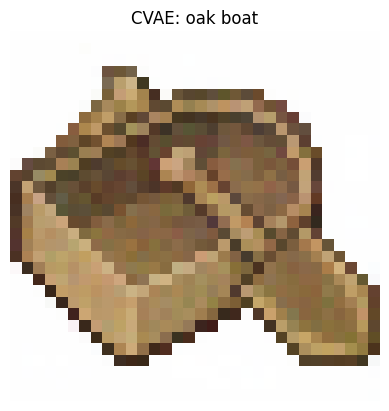

Época [400/4000] Loss Total: 14.4895 | Recon (MSE): 13.5470 | KL: 9.4248


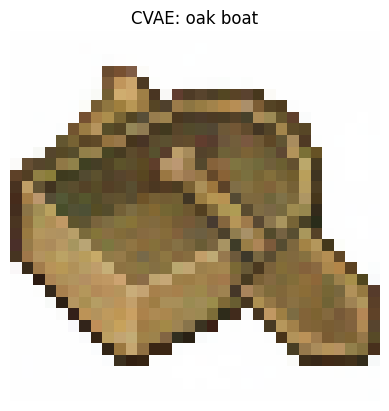

Época [500/4000] Loss Total: 8.8967 | Recon (MSE): 8.1214 | KL: 7.7531


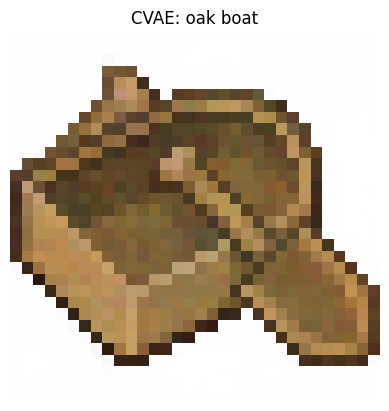

Época [600/4000] Loss Total: 14.8472 | Recon (MSE): 13.6698 | KL: 11.7735


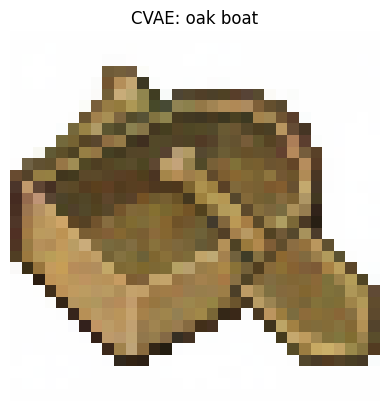

Época [700/4000] Loss Total: 8.7013 | Recon (MSE): 7.9139 | KL: 7.8743


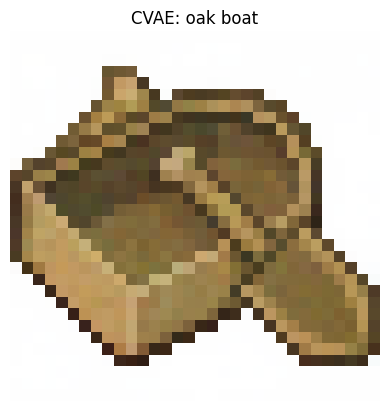

Época [800/4000] Loss Total: 7.1691 | Recon (MSE): 6.4245 | KL: 7.4461


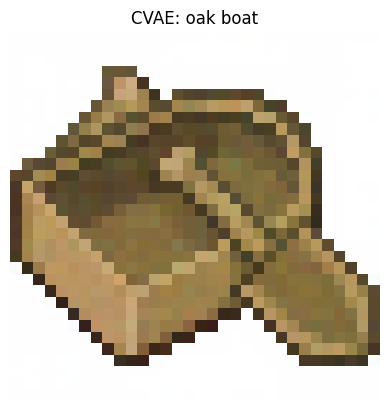

Época [900/4000] Loss Total: 5.8622 | Recon (MSE): 5.0433 | KL: 8.1893


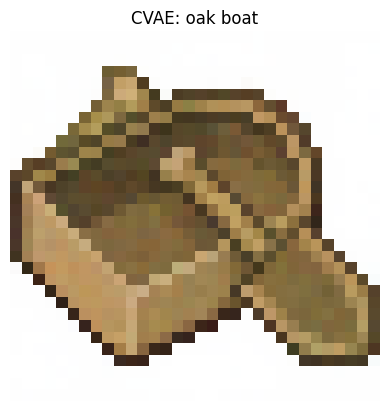

Época [1000/4000] Loss Total: 5.8685 | Recon (MSE): 4.9964 | KL: 8.7208


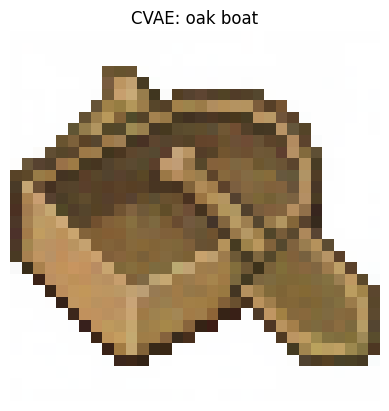

Época [1100/4000] Loss Total: 5.0647 | Recon (MSE): 4.3509 | KL: 7.1388


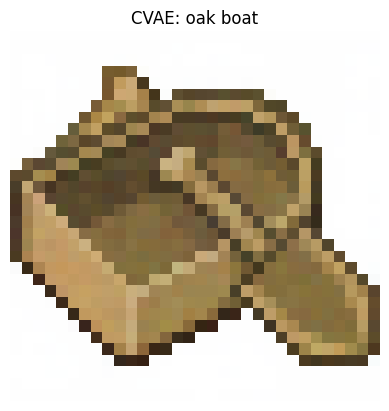

Época [1200/4000] Loss Total: 3.8351 | Recon (MSE): 3.3780 | KL: 4.5709


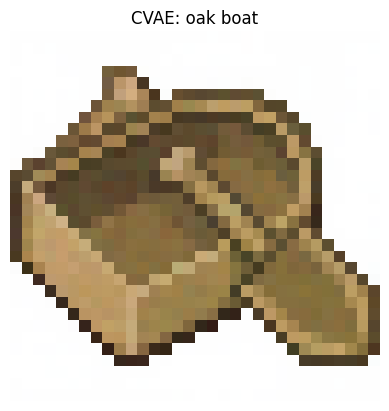

Época [1300/4000] Loss Total: 5.0577 | Recon (MSE): 4.3983 | KL: 6.5933


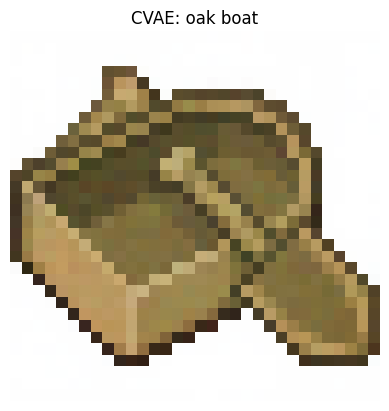

Época [1400/4000] Loss Total: 6.2139 | Recon (MSE): 5.7659 | KL: 4.4802


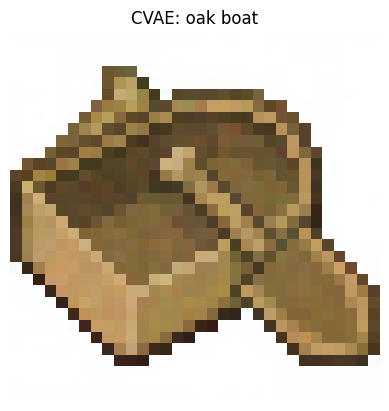

Época [1500/4000] Loss Total: 5.3036 | Recon (MSE): 4.7088 | KL: 5.9479


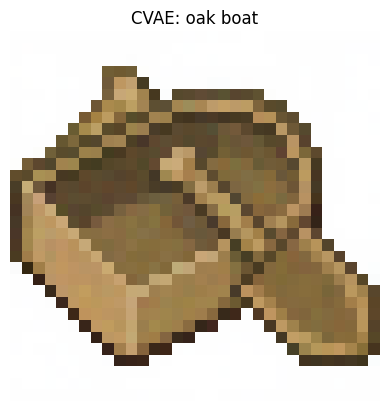

Época [1600/4000] Loss Total: 2.8916 | Recon (MSE): 2.5205 | KL: 3.7114


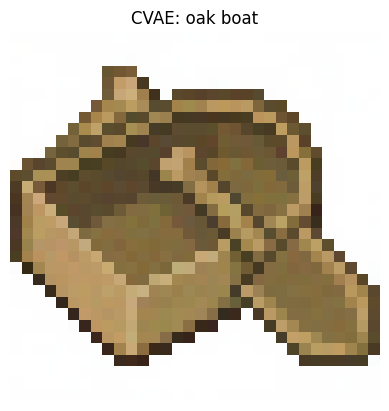

Época [1700/4000] Loss Total: 3.4804 | Recon (MSE): 2.9032 | KL: 5.7717


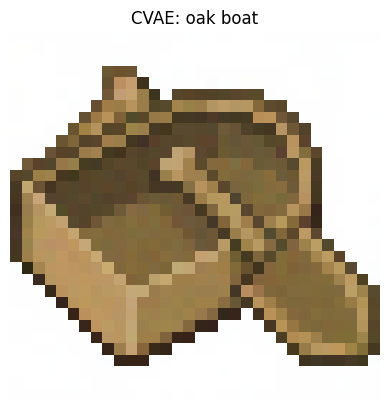

Época [1800/4000] Loss Total: 3.3641 | Recon (MSE): 2.8457 | KL: 5.1835


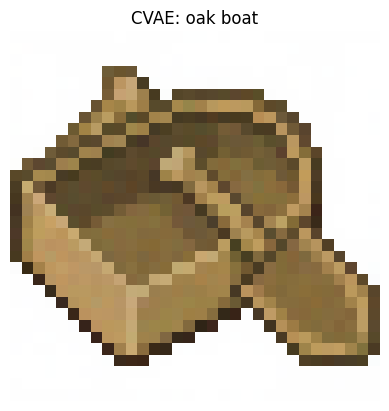

Época [1900/4000] Loss Total: 4.4350 | Recon (MSE): 3.8439 | KL: 5.9111


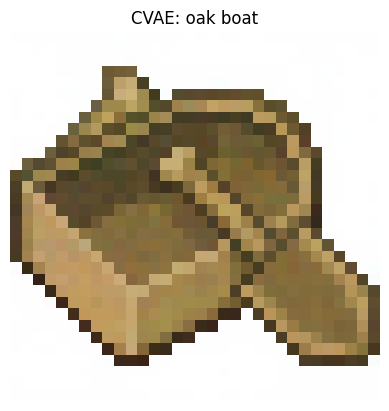

Época [2000/4000] Loss Total: 2.7524 | Recon (MSE): 2.3941 | KL: 3.5822


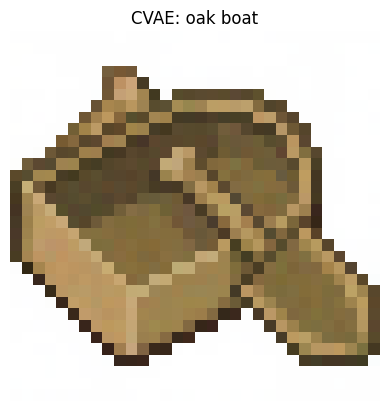

Época [2100/4000] Loss Total: 2.3523 | Recon (MSE): 1.9309 | KL: 4.2139


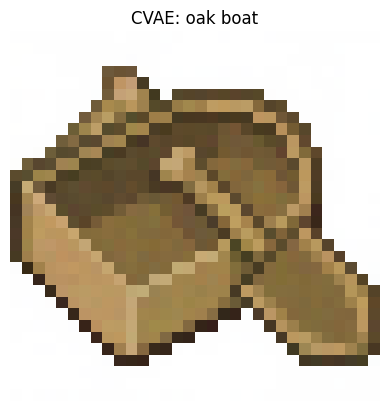

Época [2200/4000] Loss Total: 3.3464 | Recon (MSE): 2.7640 | KL: 5.8237


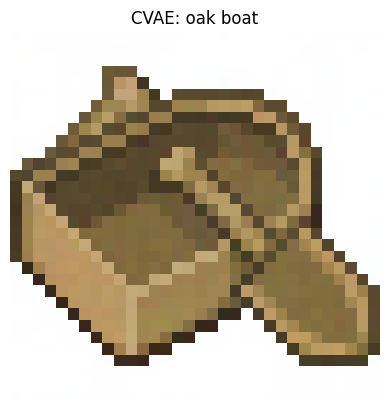

Época [2300/4000] Loss Total: 3.2465 | Recon (MSE): 2.6396 | KL: 6.0694


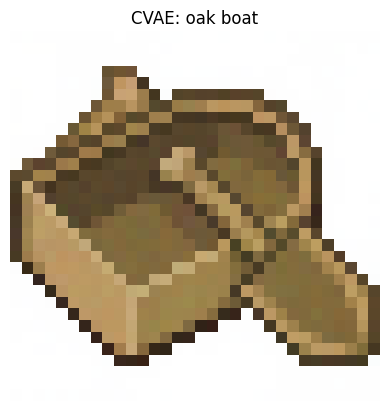

Época [2400/4000] Loss Total: 2.5570 | Recon (MSE): 2.3229 | KL: 2.3408


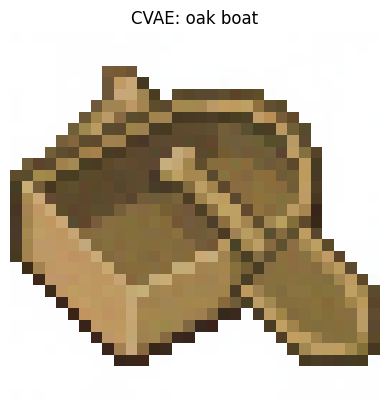

Época [2500/4000] Loss Total: 2.5541 | Recon (MSE): 2.1808 | KL: 3.7336


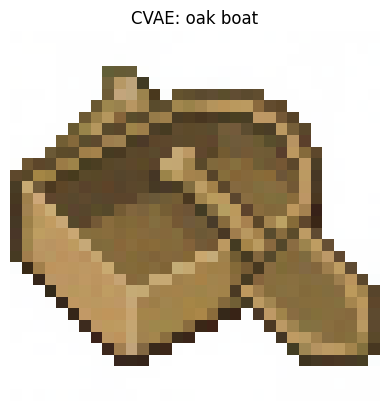

Época [2600/4000] Loss Total: 2.2843 | Recon (MSE): 1.9264 | KL: 3.5785


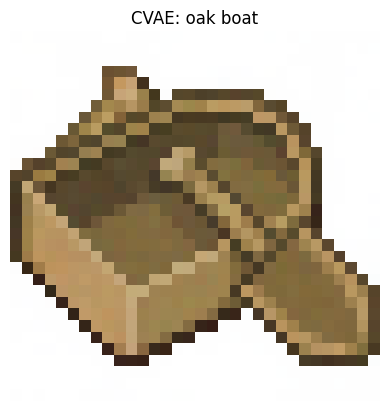

Época [2700/4000] Loss Total: 2.1209 | Recon (MSE): 1.7910 | KL: 3.2993


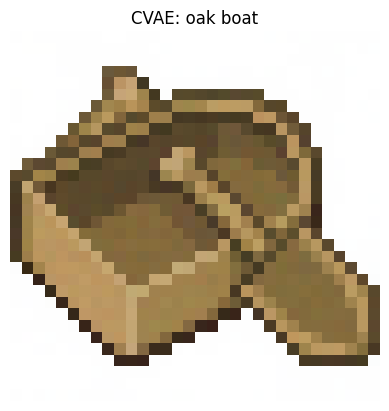

Época [2800/4000] Loss Total: 2.6397 | Recon (MSE): 2.1577 | KL: 4.8206


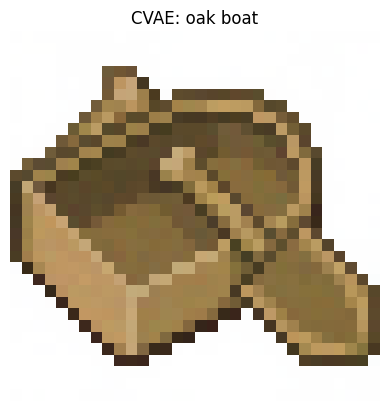

Época [2900/4000] Loss Total: 2.0096 | Recon (MSE): 1.7085 | KL: 3.0113


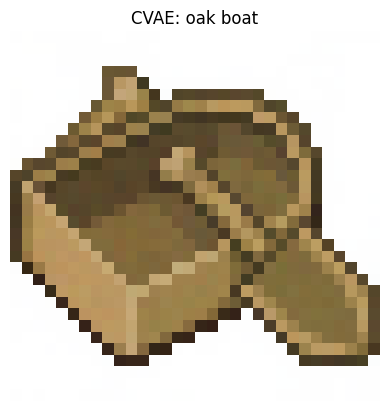

Época [3000/4000] Loss Total: 1.8378 | Recon (MSE): 1.3843 | KL: 4.5343


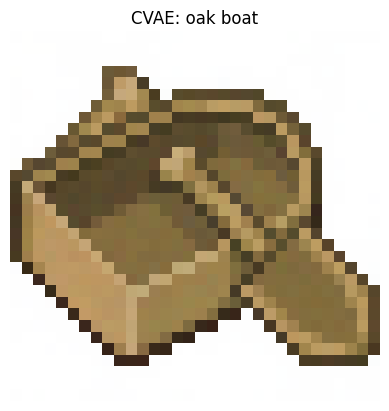

KeyboardInterrupt: 

In [78]:
num_epochs = 4000

print("Comenzando entrenamiento CVAE...")
for epoch in range(num_epochs):
    for real_imgs, labels in dataloader:
        real_imgs = real_imgs.to(device)
        
        cond_emb = txt_emb(labels).to(device)
        recon_imgs, mu, logvar = cvae(real_imgs, cond_emb)
        
        # Calcular pérdida
        loss, mse, kld = loss_function(recon_imgs, real_imgs, mu, logvar, beta=beta_kl)
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # =========================================================
    # LOGGING
    # =========================================================
    if epoch % 100 == 0: 
        print(f"Época [{epoch}/{num_epochs}] "
              f"Loss Total: { loss.item():.4f} | Recon (MSE): {mse.item():.4f} | KL: {kld.item():.4f}")

        # Generar una imagen de ejemplo condicional
        cvae.eval() 
        with torch.no_grad():
            test_prompt = "oak boat" 
            test_emb = txt_emb([test_prompt]).to(device)
            
            z = torch.randn(1, latent_dim, device=device)
            fake_test = cvae.decoder(z, test_emb).detach().cpu()

            # Visualización
            img_vis = (fake_test[0] * 0.5 + 0.5).clamp(0, 1)
            plt.imshow(TF.to_pil_image(img_vis))
            plt.title(f"CVAE: {test_prompt}")
            plt.axis("off")
            plt.show()
        cvae.train() # Volver a modo entrenamiento

#### Guardar modelos

In [ ]:
# GUARDAR MODELOS
import os
import torch

version = "v1" 
save_dir = f"./modelos/{version}"

os.makedirs(save_dir, exist_ok=True)

# === Guardar modelos ===
torch.save(E.state_dict(), os.path.join(save_dir, "encoder.pth"))
torch.save(D.state_dict(), os.path.join(save_dir, "decoder.pth"))
torch.save(cvae.state_dict(), os.path.join(save_dir, "cvae.pth"))
torch.save(txt_emb.state_dict(), os.path.join(save_dir, "text_embedding.pth"))

print(f" Modelos guardados en: {save_dir}")


#### resultados

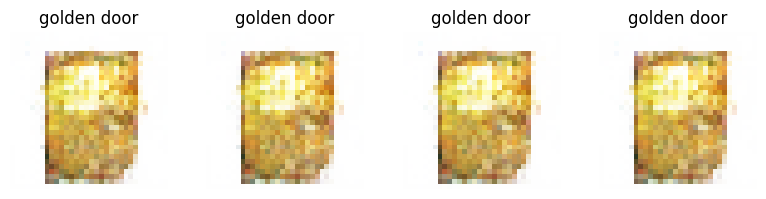

In [80]:
# Generar y mostrar
prompt = "golden door"
resultados = generar_imagenes(D, txt_emb, prompt, latent_dim=latent_dim)
mostrar_resultados(resultados)


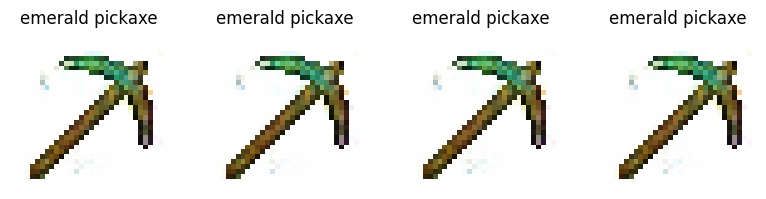

In [87]:
prompt = "emerald pickaxe"
imgs = generar_imagenes(D, txt_emb, prompt, latent_dim=latent_dim)
mostrar_resultados(imgs)


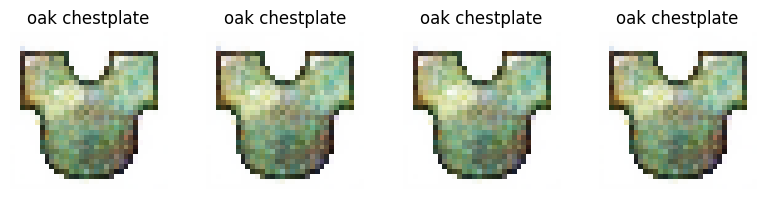

In [88]:
prompt = "oak chestplate"
imgs = generar_imagenes(D, txt_emb, prompt, latent_dim=latent_dim)
mostrar_resultados(imgs)

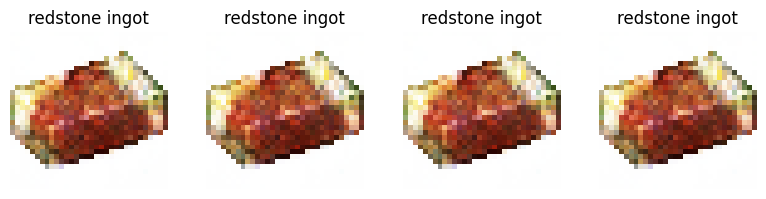

In [89]:
prompt = "redstone ingot"
imgs = generar_imagenes(D, txt_emb, prompt, latent_dim=latent_dim)
mostrar_resultados(imgs)

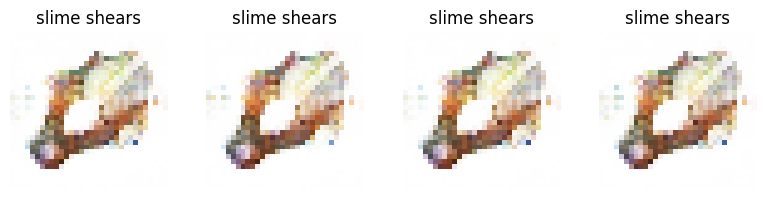

In [90]:
prompt = "slime shears"
imgs = generar_imagenes(D, txt_emb, prompt, latent_dim=latent_dim)
mostrar_resultados(imgs)

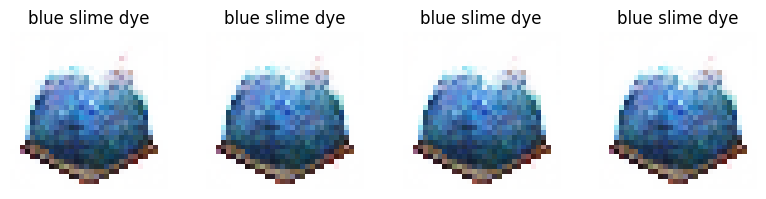

In [91]:
prompt = "blue slime dye"
imgs = generar_imagenes(D, txt_emb, prompt, latent_dim=latent_dim)
mostrar_resultados(imgs)

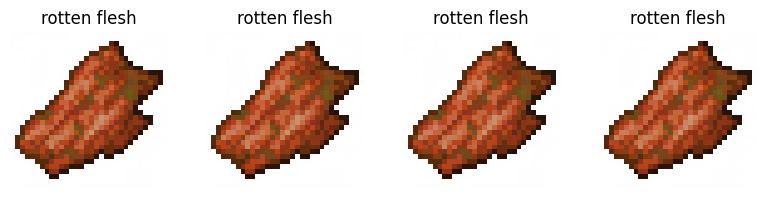

In [92]:
prompt = "rotten flesh"
imgs = generar_imagenes(D, txt_emb, prompt, latent_dim=latent_dim)
mostrar_resultados(imgs)

#### Importar modelos

In [ ]:
import torch
import os

# === Configuración ===
device = "cuda" if torch.cuda.is_available() else "cpu"
version = "v1"  
embed_dim = 100 
save_dir = f"./modelos/{version}"

# Construir vocabulario
all_labels = df["label"].tolist()
cleaned_labels = [re.sub(r"\d+", "", lbl).strip() for lbl in all_labels]
all_labels = list(set(cleaned_labels))
vocab = TextEmbedding.build_vocab(all_labels)

# === Inicializar modelos ===
txt_emb = TextEmbedding(vocab, embed_dim=embed_dim).to(device)
D = Decoder(embed_dim=embed_dim, latent_dim=latent_dim, ngf=ngf).to(device)

# === Cargar pesos ===
D.load_state_dict(torch.load(os.path.join(save_dir, "decoder.pth"), map_location=device))
txt_emb.load_state_dict(torch.load(os.path.join(save_dir, "text_embedding.pth"), map_location=device))

# === Pasar a modo evaluación ===
D.eval()
txt_emb.eval()

print(" Modelos cargados correctamente desde", save_dir)
